# Machine Learning (with `jax`)

In [1]:
import jax
import jax.numpy as np
import jax.lax as lax
import jax.scipy.stats as stats

In [2]:
import numpy as np0
import matplotlib.pyplot as plt

In [3]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [4]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [5]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

In [6]:
import tools.machine as ml

## Linear Regression

Here we're considering the case of a linear model with Guassian noise. In this case, the likelihood function looks like

$$
\log(\mathcal{L}) = -\frac{N}{2}\log(2\pi)-N\log(\sigma)-\sum_i \frac{1}{2}\left(\frac{y_i-\beta x_i}{\sigma}\right)^2
$$

First let's just use pure `numpy` to generate some random data. No need to mess around with the `jax` system here.

In [7]:
# generate random data
N = 1000
β0t, β1t, σ = 3.0, 2.0, 0.5
dat_x = np0.random.randn(N)
dat_y = β0t + β1t*dat_x + σ*np0.random.randn(N)

Now we'll make a function to evaluate the mean squared error (`mse`), compute its derivative, then create an updating function.

In [8]:
# make a function that evaluates model fit
def regress_loss(c, x, y):
    β0, β1 = c['β0'], c['β1']
    yhat = β0 + β1*x
    loss = np.mean((yhat-y)**2)
    return -loss
d_regress_loss = jax.value_and_grad(regress_loss)

In [9]:
# make a function that updates coefficients
def update_coeff(c, dc, Δ):
    return jax.tree_map(lambda a, b: a + Δ*b, c, dc)
def regress_update(c, t):
    mse, dc = d_regress_loss(c, dat_x, dat_y)
    c1 = update_coeff(c, dc, 0.01)
    ret = {'coeff': c1, 'mse': -mse}
    return c1, ret
j_regress_update = jax.jit(regress_update)

Finally, we run this through scan and plot the results.

In [10]:
# run the update a fixed number of times
c0 = {'β0': 2.0, 'β1': 1.0}
c1, hist = lax.scan(j_regress_update, c0, np.arange(500))

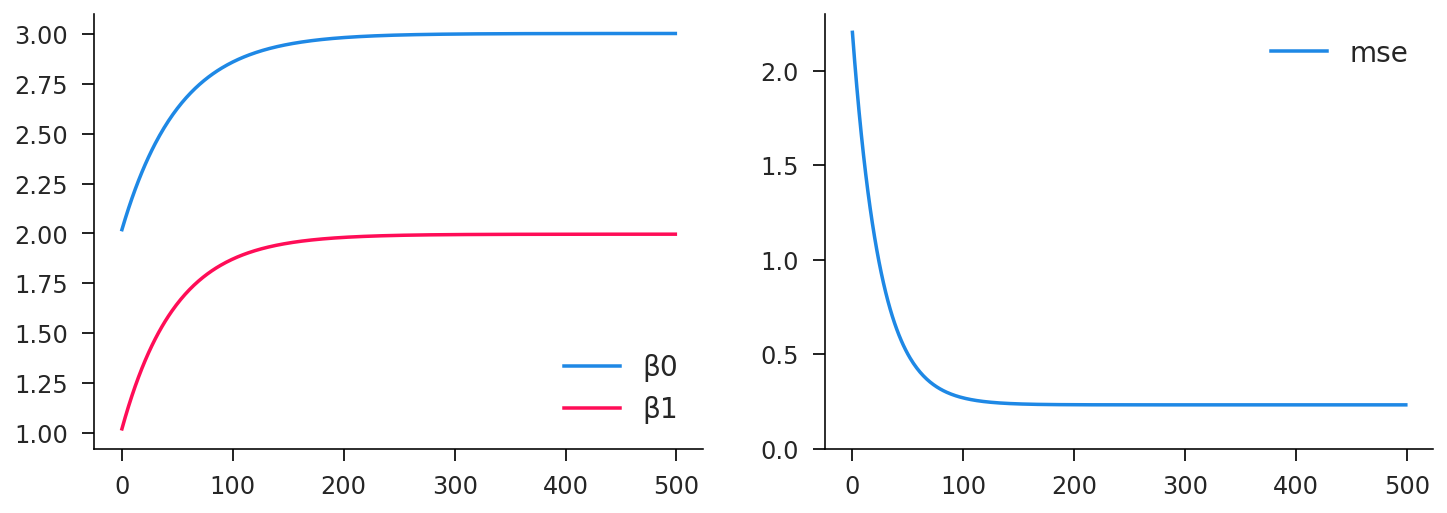

In [11]:
df = pd.DataFrame({**hist['coeff'], 'mse': hist['mse']})
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))
df[['β0', 'β1']].plot(ax=ax0); df[['mse']].plot(ax=ax1, ylim=(0, None));

## Logistic Regression

In [12]:
# binary crossentry is really just a likelihood for a categorical outcome
def binary_crossentropy(logits, y):
    probs = 1/(1+np.exp(-logits))
    like = np.where(y, probs, 1-probs)
    return -np.log(like)

In [13]:
# split loss into predict and loss functions
def logit_predict(c, x):
    β0, β1 = c['β0'], c['β1']
    return β0 + x @ β1
def logit_loss(c, x, y):
    logits = logit_predict(c, x)
    like = binary_crossentropy(logits, y)
    loss = np.mean(like)
    return -loss
d_logit_loss = jax.grad(logit_loss)

In [14]:
# compute dictionary of stats for fit
def logit_stats(c, x, y):
    β0, β1 = c['β0'], c['β1']

    # coefficient distribution
    β1avg = np.mean(β1)
    β1std = np.sqrt(np.mean(β1**2)-β1avg**2)

    # prediction
    logits = logit_predict(c, x)
    predict = logits >= 0.0 # point prediction in {0,1}
    predavg = np.mean(predict)

    # fit assessment
    accuracy = np.mean(predict == y)
    false_pos = np.mean(predict & ~y)
    false_neg = np.mean(~predict & y)

    # return detached
    return {
        'β0': β0, 'β1avg': β1avg, 'β1std': β1std, 'accuracy': accuracy,
        'false_pos': false_pos, 'false_neg': false_neg
    }

In [15]:
# make a function that updates coefficients
def logit_estimate(x, y, K=500, Δ=0.01):
    N, M = x.shape

    # initial coefficient guess
    c0 = {
        'β0': 0.1*np0.random.randn(),
        'β1': 0.1*np0.random.randn(M),
    }

    # iterate and return
    update = lambda c, t: (
        update_coeff(c, d_logit_loss(c, x, y), Δ),
        logit_stats(c, x, y)
    )
    return lax.scan(update, c0, np.arange(K))
j_logit_estimate = jax.jit(logit_estimate, static_argnames='K')

## Linear Data

In [16]:
# simple hyperplane model
dim = 100
β0t = 0.0
β1t = 1.0*np.ones(dim)

In [17]:
# more random data
N = 10000
space = np0.random.randn(N, dim)
rando = np0.random.logistic(size=N)
categ = β0t + space @ β1t + rando > 0
print(np.mean(categ))

0.4906


In [18]:
coeff, history = logit_estimate(space, categ, K=2000, Δ=2.0)
print(f'beta0 = {coeff["β0"]}')
print(f'b1avg = {coeff["β1"].mean()}')
print(f'b1std = {coeff["β1"].std()}')

beta0 = 0.0798761323094368
b1avg = 1.0140775442123413
b1std = 0.05182516947388649


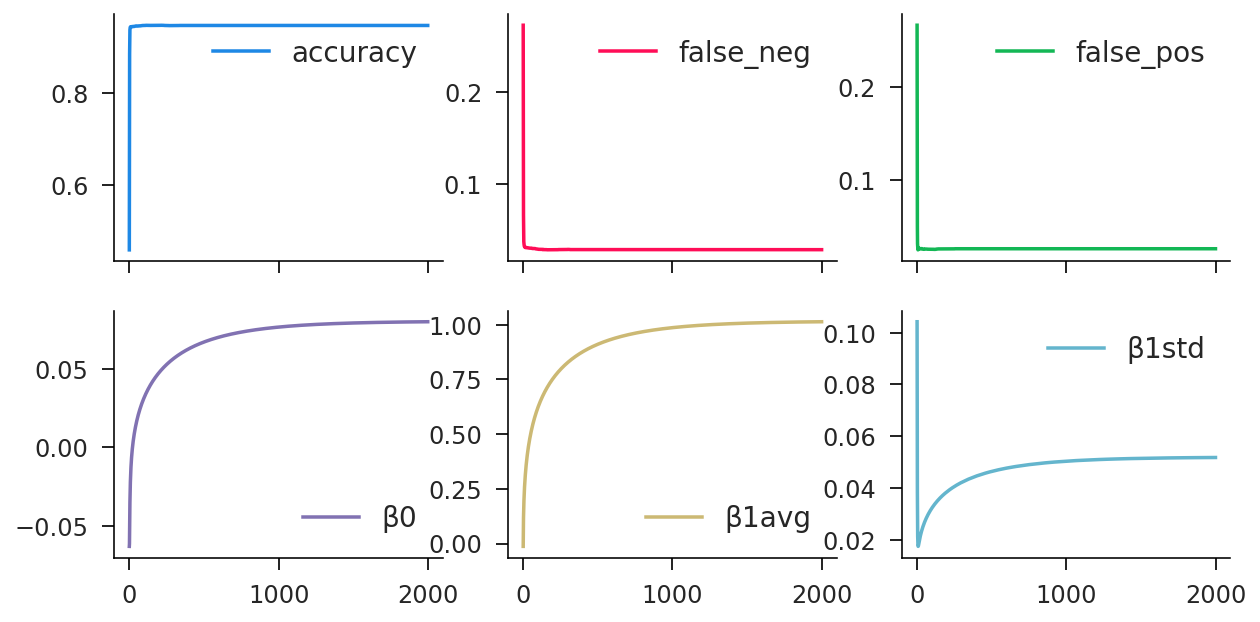

In [19]:
df = pd.DataFrame(history)
df.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

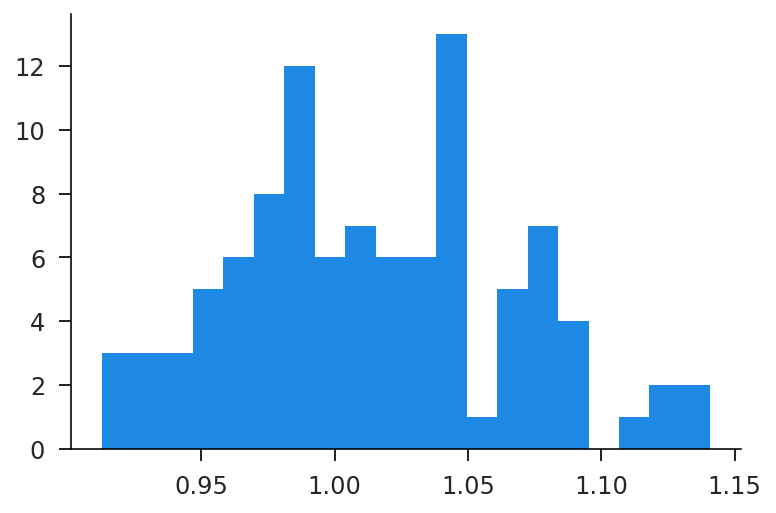

In [20]:
plt.hist(coeff['β1'], bins=20);

In [21]:
# look at out of sample properties (validation accuracy)
val_space = np0.random.randn(N, dim)
val_rando = np0.random.logistic(size=N)
val_categ = β0t + val_space @ β1t + val_rando > 0
val_stats = logit_stats(coeff, val_space, val_categ)
print('\n'.join([f'{k} = {v}' for k, v in val_stats.items()]))

β0 = 0.0798761323094368
β1avg = 1.0140775442123413
β1std = 0.05182456225156784
accuracy = 0.9382999539375305
false_pos = 0.03219999745488167
false_neg = 0.029500000178813934


### Non-linear data

In [22]:
N = 10000
space = np0.random.randn(N, dim)
categ = np.sqrt(np.sum(space**2, axis=1)) < np.sqrt(dim)
print(np.mean(categ))

0.5169


In [23]:
coeff, history = logit_estimate(space, categ, K=100, Δ=2.0)
print(f'beta0 = {coeff["β0"]}')
print(f'b1avg = {coeff["β1"].mean()}')
print(f'b1std = {coeff["β1"].std()}')

beta0 = 0.06896476447582245
b1avg = 0.0008207286591641605
b1std = 0.018694791942834854


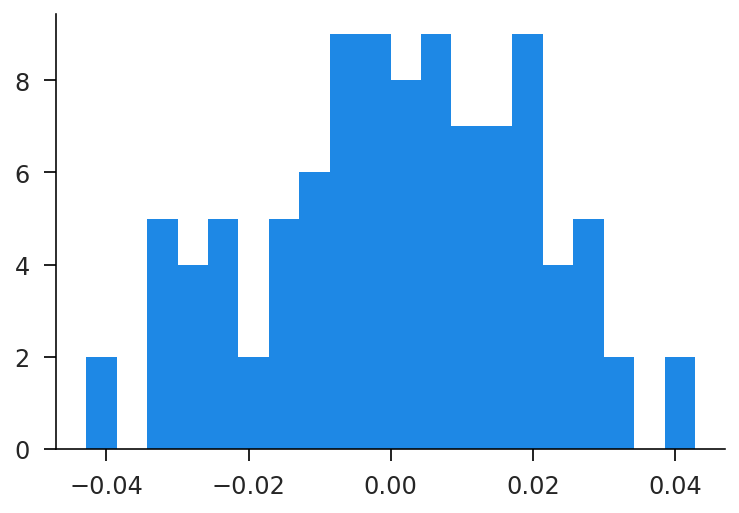

In [24]:
plt.hist(coeff['β1'], bins=20);

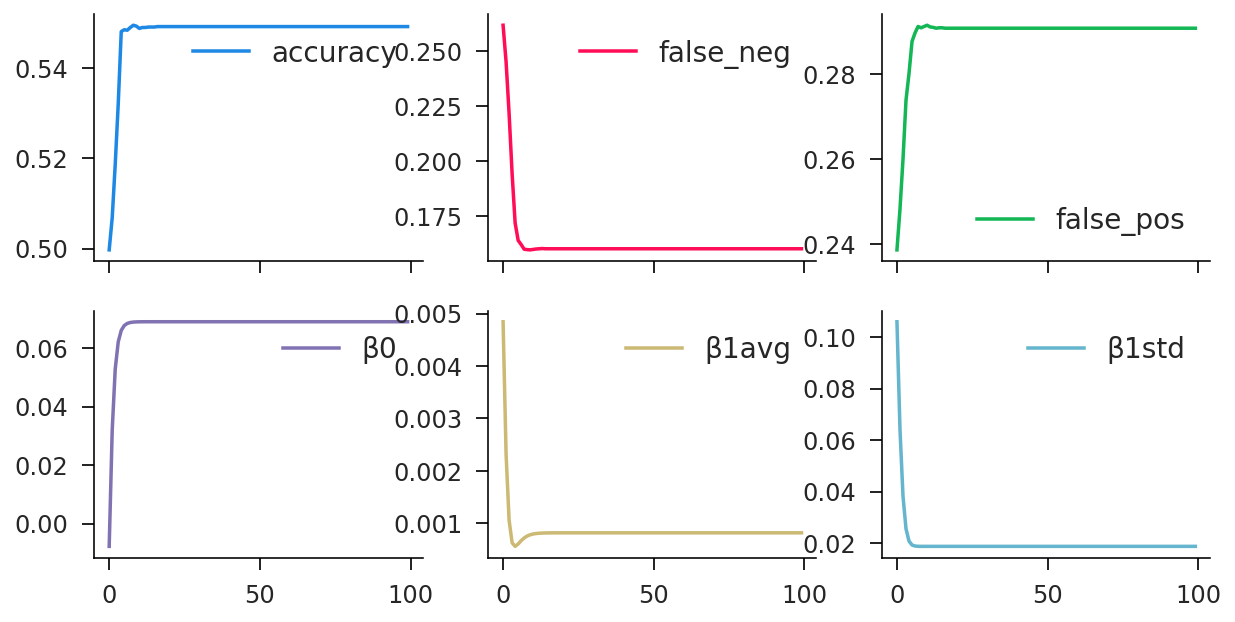

In [25]:
df = pd.DataFrame(history)
df.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

In [26]:
# look at out of sample properties (validation accuracy)
val_space = np0.random.randn(N, dim)
val_categ = np.sqrt(np.sum(val_space**2, axis=1)) < np.sqrt(dim)
val_stats = logit_stats(coeff, val_space, val_categ)
print('\n'.join([f'{k} = {v}' for k, v in val_stats.items()]))

β0 = 0.06896476447582245
β1avg = 0.0008207286591641605
β1std = 0.018694790080189705
accuracy = 0.5041999816894531
false_pos = 0.30629998445510864
false_neg = 0.18949998915195465
